# 09 - Clasificación de textos con Scikit-Learn

* En este notebook vamos a ver como clasificar una serie de Tweets en Ingles sobre críticas a los productos de Apple.


* Estos tweets estan clasificados como: *positivos*, *neutros* o *negativos*


* El este notebook realizaremos los siguientes pasos:
    
    1. Carga de los datos (tweets)
    2. Normalización (en ingles) de los tweets
    3. Creacción de la Bolsa de Palabras
    4. Particionado de Datos
    5. Creacción de modelos
        - Multinomial Naive Bayes
        - Bernoulli Naive Bayes
        - Regresion Logistica
        - Support Vector Machine
        - Random Forest <sup>(*)Meta-Modelo</sup>
    6. Evaluación de los modelos

<hr>


## Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. Para ello ***leeremos el csv con pandas*** (pasandolo a un dataframe) y posteriormente lo transformaremos en una lista de tuplas (*tweets*) donde cada tupla esta formada por:
    - **Posición 0**: Tweet
    - **Posición 1**: Polaridad (Positivo | Neutro | Negativo)

In [1]:
import pandas as pd
tweets_file = './data/Apple_Tweets.csv'
df = pd.read_csv(tweets_file, header=None)
tweets = [tuple(x) for x in df.values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 3804


<hr>


## Normalización

* Para este ejemplo haremos uso de ***spaCy***, pero en este caso tenemos que utilizar (e importar) el modelo para Inglés. Para ello: debemos de abrir un terminal en python y ejecutar lo siguiente para descargar el modelo en Ingles (*NOTA: los que uséis conda, tener activado el entorno*).


```
>> python3 -m spacy download en_core_web_sm
```


<img src="./imgs/010_spacy_en_download.png" style="width: 600px;"/>


* Para ***normalizar*** los tweets realizaremos las siguientes acciones:
    1. Pasamos las frases a minúsculas.
    2. Eliminamos los signos de puntuación.
    3. Eliminamos las palabras con menos de 3 caracteres.
    4. Eliminamos las Stop-Words.
    5. Eliminamos las palabras que empiecen por '@' o 'http'.
    6. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: *De cara a la normalización de textos se pueden realizar más acciones que las que vamos a realizar, pero con estas serán más que suficientes para realizar un ejercicio con fines didácticos*
    

In [2]:
#!python3 -m spacy download en_core_web_sm

In [3]:
import spacy

from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = [doc[1] for doc in tweets]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(tqdm(sentenses)):
        sentense = nlp(sentense.lower()) # Paso la frase a minúsculas y a un objeto de la clase Doc de Spacy
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop) 
                                     and (not word.text.startswith('@')) and (not word.text.startswith('http'))])
    return sentenses

# Normalizamos las frases
X = normalize(X)

100%|██████████| 3804/3804 [00:22<00:00, 172.11it/s]


<hr>


## Bolsa de Palabras


* El siguiente paso es transformar los tweets a una bolsa de palabras de frecuencias para que sirva de entrada al modelo.


* Dado que ya estamos trabajando con un corpus relativamente grande, es necesario reducir el diccionario de palabras (no confundir con un diccionario Python) para trabajar solo con las palabras más relevantes.


* La implementación de la clase "*CountVectorizer*" de scikit, permite quedarnos con las palabras más relevante. Para ello podemos utilizar dos parámetros que son:
    - **max_features**: Con este parámetro le indicamos que nos seleccione la '*X*' palabras más frecuentes del corpus. En este ejemplo **seleccionaremos las 1000 más frecuentes**.
    - **min_df**: Con este parámetro le indicamos el número mínimo de documentos en la que tiene que aparecer la palabra para que se incluya en la bolsa de palabras. En este ejemplo **seleccionaremos 3 documentos** (tweets).
    

* ***NOTA***: para más información podéis mirar la documentación de la clase "*CountVectorizer*" en: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, min_df=3)

# Pasamos los tweets normalizados a Bolsa de palabras
X = vectorizer.fit_transform(X)

<hr>


## Particionado de Datos (Train y Test)

* Vamos a particionar los datos en conjunto de Train y Test.


* Para este ejemplo nos vamos a quedar con:
    - 80% de datos de entrenamiento
    - 20% de datos de test

In [5]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Número de Tweets para el entrenamiento: {num}'.format(num=X_train.shape[0]))
print('Número de Tweets para el test: {num}'.format(num=X_test.shape[0]))

Número de Tweets para el entrenamiento: 3043
Número de Tweets para el test: 761


<hr>


## Creacción del Modelo


* Una vez tenemos creada la bolsa de palabras, podemos usar cualquier algoritmo de aprendizaje para la clasificación.


* Para este ejemplo vamos a usar los siguientes algoritmos de aprendizaje:

    - Multinomial Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    - Bernoulli Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
    - Regresion Logistica: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    - Support Vector Machine Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    - Random Forest (ensemble): https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    

* Para esta caso vamos a crear el modelo y calcular el accuracy para los datos de entrenamiento y tener una idea de que modelo puede funciona mejor:

In [6]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm_lin = SVC(kernel='linear')
svm_poly = SVC(kernel='poly')
svm_rbf = SVC(kernel='rbf')
svm_sig = SVC(kernel='sigmoid')
rf_20 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=20, random_state=0)
rf_50 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0)

clasificadores = {'Multinomial NB': mnb,
                  'Bernoulli NB': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM polinomico': svm_poly,
                  'SVM Kernel rbf': svm_rbf,
                  'SVM Kernel Sigmoid': svm_sig,
                  'Random Forest d_20': rf_20,
                  'Random Forest d_50': rf_50}


# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    v.fit(X_train, y_train)

CREANDO MODELO: Multinomial NB
CREANDO MODELO: Bernoulli NB
CREANDO MODELO: Regresion Logistica
CREANDO MODELO: SVM lineal
CREANDO MODELO: SVM polinomico
CREANDO MODELO: SVM Kernel rbf
CREANDO MODELO: SVM Kernel Sigmoid
CREANDO MODELO: Random Forest d_20
CREANDO MODELO: Random Forest d_50


<hr>


## Evaluación del Modelo


* Para cada uno de los modelos vamos a calcular las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **Precision**
    3. **Recall**
    4. **F1**

In [7]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

def evaluation(model, name, X_train, y_train, X_test, y_test):
    """
    Función de devuelve en un diccionario las métricas de evaluación de 
    Accuracy, Precision, Recall y F1 para los conjuntos de datos de entrenamiento y test
        model: modelo a evaluar
        name: nombre del modelo
        X_train: Variables de entrada del conjunto de datos de entrenamiento
        y_train: Variable de salida del conjunto de datos de entrenamiento
        X_test: Variables de entrada del conjunto de datos de test
        y_test: Variable de salida del conjunto de datos de test
        return: diccionario con el nombre del modelo y el valor de las métricas
    """
    model_dict = {}
    model_dict['name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    model_dict['accuracy_train'] = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['accuracy_tests'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['precision_train'] = precision_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['precision_tests'] = precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['recall_train'] = recall_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['recall_tests'] = recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['f1_train'] = f1_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['f1_tests'] = f1_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    
    return model_dict


# Calculamos las métricas de los modelos por separado
evaluacion = list()
for key, model in clasificadores.items():
    evaluacion.append(evaluation(model=model, name=key, 
                                 X_train=X_train, y_train=y_train,
                                 X_test=X_test, y_test=y_test))

# Pasamos los resultados a un DataFrame para visualizarlos mejor
df = pd.DataFrame.from_dict(evaluacion)
df.set_index("name", inplace=True)
df

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
name,,,,,,,,
Multinomial NB,0.780151,0.721419,0.783864,0.727190,0.780151,0.721419,0.781169,0.723901
Bernoulli NB,0.755176,0.716163,0.766085,0.726448,0.755176,0.716163,0.755911,0.718362
Regresion Logistica,0.867236,0.743758,0.872877,0.736569,0.867236,0.743758,0.863562,0.733259
SVM lineal,0.876438,0.743758,0.880638,0.738571,0.876438,0.743758,0.873497,0.736051
SVM polinomico,0.818600,0.668857,0.859948,0.702568,0.818600,0.668857,0.804748,0.616968
SVM Kernel rbf,0.852120,0.751643,0.867852,0.753920,0.852120,0.751643,0.843071,0.730173
SVM Kernel Sigmoid,0.760762,0.738502,0.761450,0.733404,0.760762,0.738502,0.738734,0.716475
Random Forest d_20,0.747289,0.714849,0.810116,0.757355,0.747289,0.714849,0.713381,0.672328
Random Forest d_50,0.850148,0.737188,0.879406,0.756099,0.850148,0.737188,0.843052,0.713749


* Representamos las métricas para los diferentes modelos en un gráfico de barras:

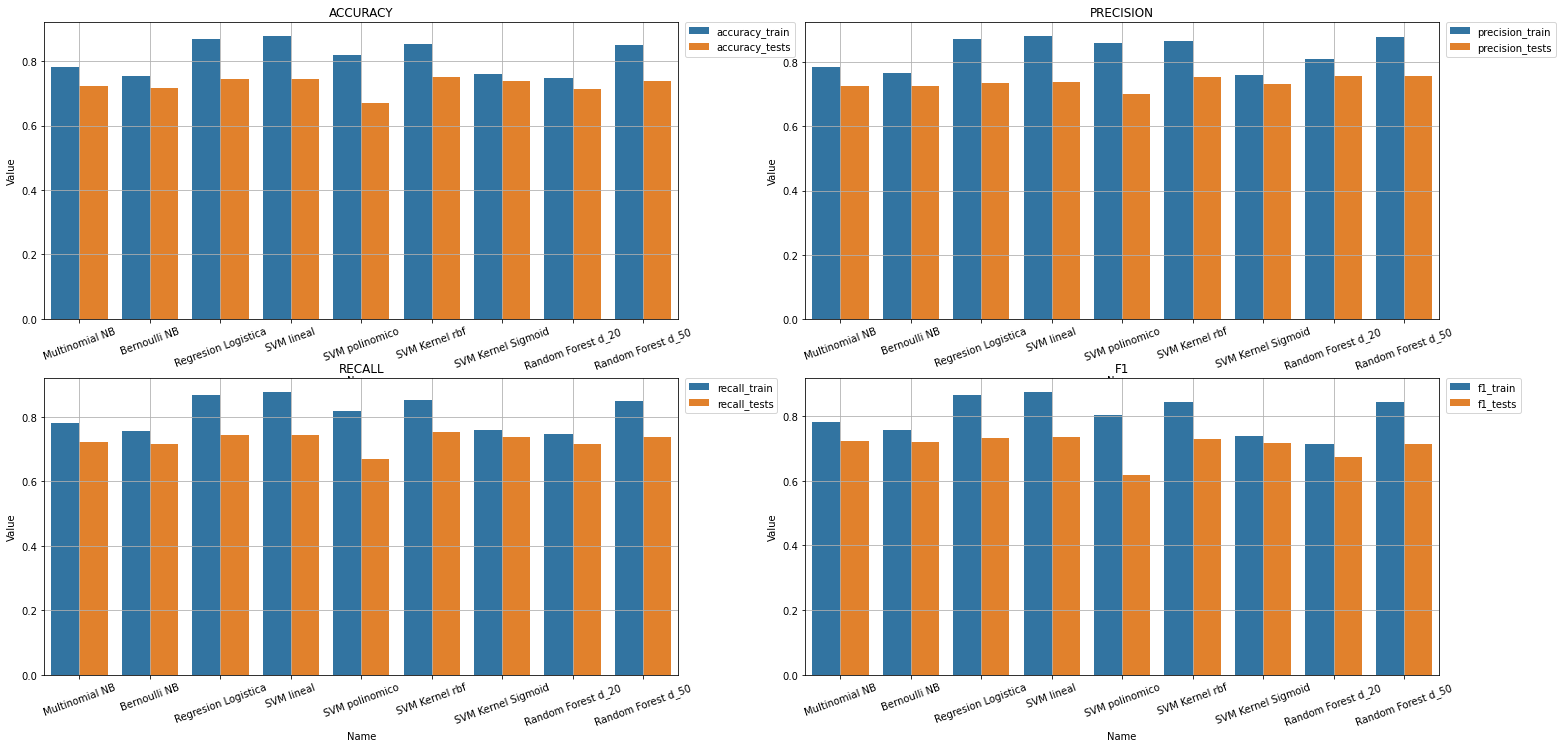

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Métricas a pintar
METRICS = ["accuracy", "precision", "recall", "f1"]

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = df.reset_index().melt(id_vars='name').rename(columns=str.title)

plt.figure(figsize=(25, 12))
pos = 1
for metric in METRICS:
    # Filtramos la métrica a pintar
    df_aux = df_plot[df_plot['Variable'].str.contains(metric)]
    
    # Pintamos la gráfica en su posición 2x2
    plt.subplot(2, 2, pos)
    sns.barplot(x='Name', y='Value', hue='Variable', data=df_aux)
    plt.title(metric.upper())
    plt.grid()
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=20)
    pos += 1
plt.show()

* Veamos las matrices de confusión de los modelos

Obteniendo Matriz de Confusión de: Multinomial NB
Obteniendo Matriz de Confusión de: Bernoulli NB
Obteniendo Matriz de Confusión de: Regresion Logistica
Obteniendo Matriz de Confusión de: SVM lineal
Obteniendo Matriz de Confusión de: SVM polinomico
Obteniendo Matriz de Confusión de: SVM Kernel rbf
Obteniendo Matriz de Confusión de: SVM Kernel Sigmoid
Obteniendo Matriz de Confusión de: Random Forest d_20
Obteniendo Matriz de Confusión de: Random Forest d_50


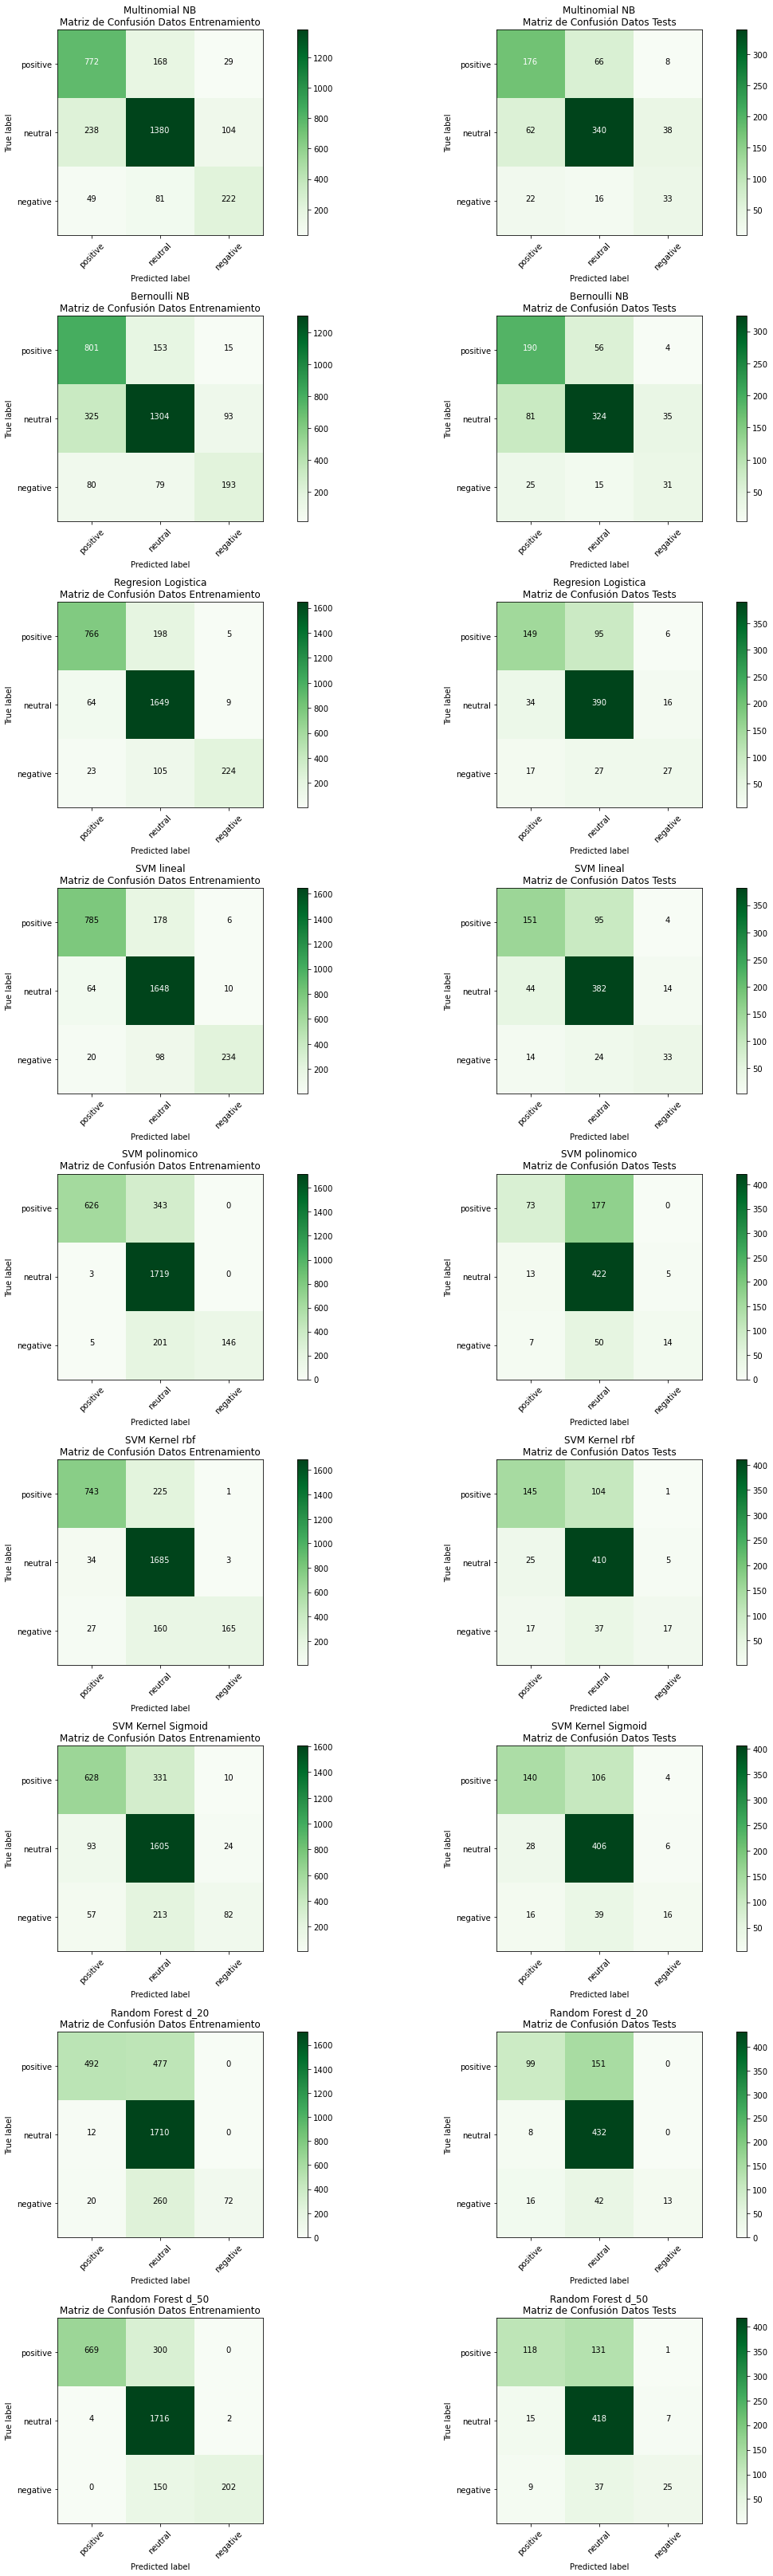

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

# Obtenemos las Matrices de confusión
msc = list()
for k, v in clasificadores.items():
    print ('Obteniendo Matriz de Confusión de: {model}'.format(model=k))
    model = {}
    model['name'] = k
    y_pred_train = v.predict(X_train)
    y_pred_test = v.predict(X_test)
    model['confusion_matrix_train'] = confusion_matrix(y_true=y_train, y_pred=y_pred_train)
    model['confusion_matrix_test'] = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
    msc.append(model)

    
# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Pintamos las matrices de confusión
plt.figure(figsize=(20, 45))
pos = 0
for mc in msc:
    pos += 1
    plt.subplot(9, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_train'], classes=['positive', 'neutral', 'negative'], 
                          title='{}\nMatriz de Confusión Datos Entrenamiento'.format(mc['name']))
    pos += 1
    plt.subplot(9, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_test'], classes=['positive', 'neutral', 'negative'], 
                          title='{}\nMatriz de Confusión Datos Tests'.format(mc['name'] ))
plt.show()

<hr>


# Bonus Track I - Técnicas de Evaluación


* Para evaluar los modelos obtenidos tras la aplicación de alguna de las técnicas de ML, es necesario disponer de un ***conjunto de datos*** (etiquetados o no) para ***generar el mejor modelo  posible y minimizar el error empírico***.


* Dado un conjunto de datos, podemos enumerar los siguientes ***métodos de evaluación*** en función de cómo se dividen los datos de entrenamiento y de test:
<span></span><br><br>
    - **Resustitución**: Todos los datos disponibles se utilizan como datos de test y de entrenamiento.
<span></span><br><br>
    - **Partición (Hold Out)**: Divide los datos en dos subconjuntos: uno de entrenamiento y uno de test.
<span></span><br><br>
<img src="./imgs/021_tec_eval.png" style="width: 500px;"/>
<span></span><br><br>
    - **Validación cruzada (Cross Validation)**: Divide los datos aleatoriamente en ‘N’ bloques. Cada bloque se utiliza como test para un sistema entrenado por el resto de bloques.
<span></span><br><br>
<img src="./imgs/022_tec_eval.png" style="width: 500px;"/>
<span></span><br><br>
    - **Exclusión individual (Leave One Out)**: Este método utiliza cada dato individual como dato único de test de un sistema entrenado con todos los datos excepto el de test.
<span></span><br><br>
<img src="./imgs/023_tec_eval.png" style="width: 500px;"/>


<hr>


# Bonus Track II - Evaluacion de Modelos de Clasificación


* Para los problemas de Clasificación se utilizan (entre otros) las siguientes métricas de evaluación:

    - ***Accuracy***
    - ***Precision***
    - ***Recall***
    - ***Specificity***
    - ***F-score***
    - ***Curva ROC***
    -  ***ROC_AUC: Área sobre la curva ROC***


* Para ver como clasifica el modelo generado usamos la denominada ***“Matriz de Confusión”*** en la cual se muestra el número de elementos que clasifica como verdaderos y falsos positivos y verdaderos y falsos negativos.


* Veamos a continuación los detalles de las métricas de evaluación y la matriz de confusión:


<hr>


## - Matriz de confusión

* Cuando hablamos de clasificación tenemos que medir cuanto hemos acertado y como lo hemos acertado, por ello las ***matrices de confusión nos ayudan a ver el acierto o fallo que tiene nuestro modelo a la hora de clasificar***. La matriz de confusión tiene la siguiente forma:

    - **True Positive (TP)**: Valores positivos clasificados como positivos
    - **True Negative (TN)**: Valores negativos clasificados como negativos
    - **False Positive (FP)**: Valores negativos clasificados como positivos
    - **False Negative (FN)**: Valore positivos clasificados como negativos
    
<img src="./imgs/011_Matriz_Confusion.png" style="width: 400px;"/>


## - Accuracy

* Indica el porcentaje de acierto:

$$Acuracy = \frac{TP + TN}{TP + FN + FP + TN}$$

## - Precision

* Los positivos correctamente pronosticados entre todos los ejemplos pronosticados como positivos. 


* "***De lo que hemos pronosticado, cuanto hemos acertado***"


$$Precision = \frac{TP}{TP + FP}$$


<img src="./imgs/012_Matriz_Confusion_precision.png" style="width: 400px;"/>
                                                               
                                                               

## - Recall


* Los positivos correctamente pronosticados, entre todos los ejemplos que son positivos. 


* "***De lo que hay en realidad, cuanto hemos acertado***"


$$Recall = \frac{TP}{TP + FN}$$


<img src="./imgs/013_Matriz_Confusion_recall.png" style="width: 400px;"/>


## - Specificity


* Los negativos correctamente pronosticados, entre todos los ejemplos que son negativos. 


$$Specificity = \frac{TN}{TN + FP} = \frac{TN}{Negative}$$


<img src="./imgs/021_eval.png" style="width: 400px;"/>


## - F-Score (Precision-Recall)


* Es una media que ***combina la precisión y el recall con la media armonica de ambas medidas***. 


* Si es cercano a ***1*** significa que la clasificación realizada es buena. 


* Si es cercano a ***0*** la clasificación realizada es mala.


* Se utiliza la media armonica, porque esta penaliza el hecho de que uno de los dos valores(el Precision o el Recall) tenga un valor bajo.


* El ***F1*** o ***F-score*** (siendo $score=1$) se calcula de la siguiente manera:


$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$


* Esta medida en realidad debería de llamarse $F_\beta$ calculandose de la siguiente manera:

$$F_\beta =  \frac{(1+\beta^2) \cdot Precision \cdot Recall}{\beta^2 \cdot Precision + Recall}$$


* En función del valor que le demos a $F_\beta$ la media armónica dará más importancia a la Precision o al Recall; por ejemplo:

    + $F_{0}$: Es el Recall.
    + $F_{0.5}$: Da más peso a la Precision que al Recall.
    + $F_{1}$: Asigna el mismo peso a la Precision que al Recall.
    + $F_{2}$: Da más peso a la Recall que a la Precision.
    + $F_{\infty}$: Es la Precision.
    
    
* ***La medida del F-Score es conocida como la medida F1 porque de esta manera se calcula la media armónica entre la Precision y el Recall otorgando a ambas el mismo peso.***


## Curva ROC


* La ***curva ROC*** (***R***eceiver ***O***perating ***C***haracteristic) es una gráfica que ***representa la Tasa de Verdaderos Positivos (TPR) en el eje vertical frente a la Tasa de Falsos Positivos (FPR) en el eje horizontal***.

    <img src="./imgs/022_eval.png" style="width: 400px;"/>

* Siendo:
<br>

    + ***TPR***: Recall
        $$TPR = Recall = \frac{TP}{TP + FN} = \frac{TP}{Positive}$$
    + ***FPR***: Fall-out
        $$FPR = Fall-Out = \frac{FP}{FP + TN} = \frac{FP}{Negative}$$

* Para ***construir esta curva***:

    1. Nuestro ***modelo de clasificación nos tiene que devolver una probabilidad o score de pertenencia a la clase positiva y debemos de ordenar esa probabilidad o score de mayor a menor valor*** (de manera decreciente).
<br>

    2. ***Al recorrer los elementos ordenados*** vemos:
        + Si nos encontramos un elemento que ***pertenece a la clase positiva (TPR) nos movemos verticalmente hacia arriba***.
        + Si nos encontremos un elemento que ***pertenece a la clase negativa (FPR) nos movemos hacia la derecha***.
        
* Por otro lado, en la curva ROC conecta siempre los puntos (0,0) y (1,1) con una recta, normalmente representada de manera punteada.


## - ROC_AUC: Área bajo la curva ROC


* El ***Área Bajo la Curva ROC (Area Under Curve), es el área que queda bajo la curva ROC*** y nos vale como una medida de precisión del clasificador.


* Un modelo que clasifique todos los elementos perfectamente, tendrá un ROC_AUC de 1.


* Cuando se representa la curva ROC se suele dibujar una curva diagonal (discontinua) que representa un clasificador cuyos elementos tienen todos la misma probabilidad o score y esta diagonal tiene un ROC_AUC de 0,5.


* Cuanto más cercana este nuestra curva ROC de la diagonal, significará que nuestro modelo es menos preciso a la hora de clasificar y cuanto más 'alejado' este de la diagonal, más preciso será nuestro modelo.


        
## - Métricas en Sckit-Learn:

* Scikit-Learn tiene implementados todos estos métodos de evaluación.


* Como norma general se le pasa como parámetros un array con la clasificación verdadera y otro array con la predicción:

    - **metrics.confusion_matrix(y_true, y_pred[, …])**: Compute confusion matrix to evaluate the accuracy of a classification
    - **metrics.accuracy_score(y_true, y_pred[, …])**: Accuracy classification score
    - **metrics.precision_score(y_true, y_pred[, …])**: Compute the precision
    - **metrics.recall_score(y_true, y_pred[, …])**: Compute the recall
    - **metrics.f1_score(y_true, y_pred[, labels, …])**: Compute the F1 score, also known as balanced F-score or F-measure
    - **metrics.classification_report(y_true, y_pred)**: Build a text report showing the main classification metrics
    - **metrics.roc_auc_score(y_true, y_score[, …])**: Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    - **metrics.roc_curve(y_true, y_score[, …])**: Compute Receiver operating characteristic (ROC)


<hr>


## Ejemplo: Clasificación Binaria


* Supongamos que tenemos que clasificar 10 elementos de dos clases y la realizadad y la predicción vienen dados por:

    - y_real =    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
    - y_predict = [1, 1, 0, 1, 1, 0, 0, 1, 1, 0]


In [10]:
y_real =    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
y_predict = [1, 1, 0, 1, 1, 0, 0, 1, 1, 0]

### - Matriz de confusión

* En el ejemplo tenemos:

    - 5 Elementos que son de la clase 0
    - 5 Elementos que son de la clase 0
    - True Positive (TP): De los que son de la clase 1, predigo 4 correctamente.
    - False Negative (FN): De los que son de la clase 1, predigo 1 incorrectamente.
    - True Negative (TN): De los que son de la clase 0, predigo 3 correctamente.
    - False Positive (FP): De los que son de la clase 0, predigo 2 incorrectamente.
    
    

* Podemos ver este resultado en la matriz de confusión:

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_real, y_pred=y_predict, labels=[1, 0])

array([[4, 1],
       [2, 3]])

### - Accuracy

* Basandonos en el ejemplo, calculamos el accuracy como:

$$Acuracy = \frac{TP + TN}{TP + FN + FP + TN} = \frac{4 + 3}{4 + 1 + 2 + 3} = \frac{7}{10} = 0.7$$

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_real, y_pred=y_predict)

0.7

### - Precision

* Basandonos en el ejemplo, calculamos la precision como:

$$Precision = \frac{TP}{TP + FP} = \frac{4}{4 + 2} = \frac{4}{6} = 0.67$$

In [13]:
from sklearn.metrics import precision_score

precision_score(y_true=y_real, y_pred=y_predict)

0.6666666666666666

### - Recall

* Basandonos en el ejemplo, calculamos el recall como:

$$Recall = \frac{TP}{TP + FN} = \frac{4}{4 + 1} = \frac{4}{5} = 0.8$$

In [14]:
from sklearn.metrics import recall_score

recall_score(y_true=y_real, y_pred=y_predict)

0.8

### - F1

* Basandonos en el ejemplo, calculamos el F1 como:

$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} = 2 \cdot \frac{0.67 \cdot 0.8}{0.67 + 0.8} = 2 \cdot \frac{0.54}{1.47} = 0.73$$

In [15]:
from sklearn.metrics import f1_score

f1_score(y_true=y_real, y_pred=y_predict)

0.7272727272727272

### - Curva ROC - Área bajo la curva

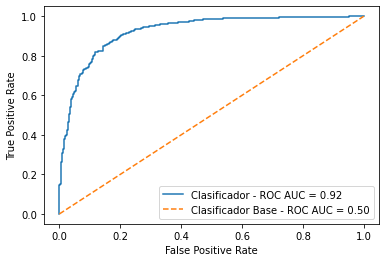

In [16]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

# Generamos un conjunto de datos de prueba con 2 clases
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)

# Creamos un Clasificador y calculamos las probabilidades de cada elemento
clf = LogisticRegression()
clf.fit(X, y)
X_probs = clf.predict_proba(X)

# Clasificador base: Clasificador con probabilidad de todos los elementos a cero
X_base_prob = [0 for i in range(len(y))]


# Obtenemos Tasa de Verdaderos Positivos (TPR), Tasa de Falsos Positivos (FPR) y el umbral
base_fpr, base_tpr, base_thresholds = roc_curve(y, X_base_prob)
clf_fpr, clf_tpr, clf_thresholds = roc_curve(y, X_probs[:, 1])

# Calculamos el Área bajo la curva
base_auc = roc_auc_score(y, X_base_prob)
clf_auc = roc_auc_score(y, X_probs[:, 1])

# Pintamos la curva ROC
plt.plot(clf_fpr, clf_tpr, label='Clasificador - ROC AUC = {:0.2f}'.format(clf_auc))
plt.plot(base_fpr, base_tpr, linestyle='--', label='Clasificador Base - ROC AUC = {:0.2f}'.format(base_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<hr>

## - Heatmap - Matriz de Confusión

* Para representar de una forma visual más agradable y legible la matriz de confusión, podemos usar el siguiente código que tiene la función "plot_confusion_matrix()"

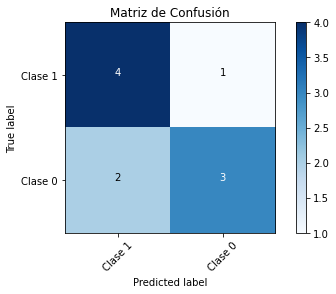

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
matriz_confusion = confusion_matrix(y_true=y_real, y_pred=y_predict, labels=[1, 0])
plot_confusion_matrix(matriz_confusion, classes=['Clase 1', 'Clase 0'], title='Matriz de Confusión')
plt.show()